# <div style="text-align: center"><font color='gray' textalign='center'>Lab 3: Classification</font></div>

In [1]:
import pandas as pd
import ds_functions as ds
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = pd.read_csv('qsar_oral_toxicity.csv', sep = ';', header = None)

data

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8987,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,negative
8988,0,1,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,negative
8989,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,negative
8990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


# <font color='gray'> Training Models </font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split

target = 1024
positive = 'positive'
negative = 'negative'
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(1024).values
X: np.ndarray = data.values

X = SelectKBest(chi2, k=100).fit_transform(X, y)
print(X.shape)

labels: np.ndarray = pd.unique(y)
labels.sort()

(8992, 100)


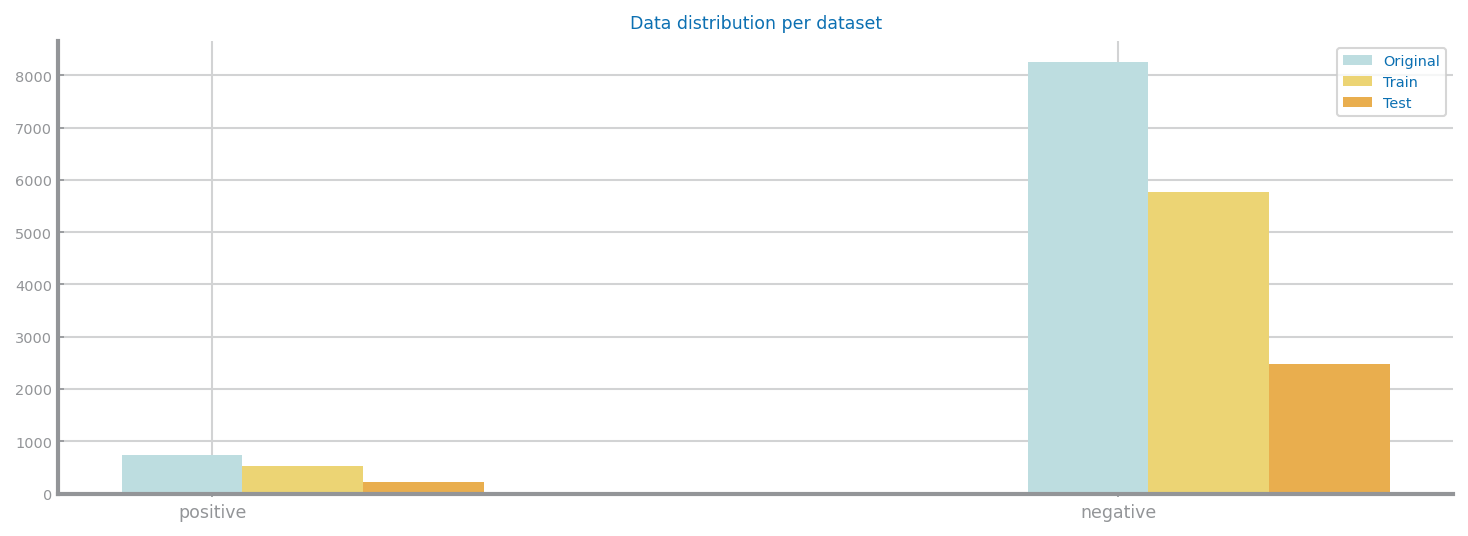

In [3]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

In [4]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(trnX, trnY)
clf.score(tstX, tstY)

0.8313565604151223

In [5]:
import numpy as np
import sklearn.metrics as metrics

prdY: np.ndarray = clf.predict(tstX)
cnf_mtx: np.ndarray = metrics.confusion_matrix(tstY, prdY, labels)
cnf_mtx

array([[2098,  378],
       [  77,  145]], dtype=int64)

<Figure size 600x450 with 0 Axes>

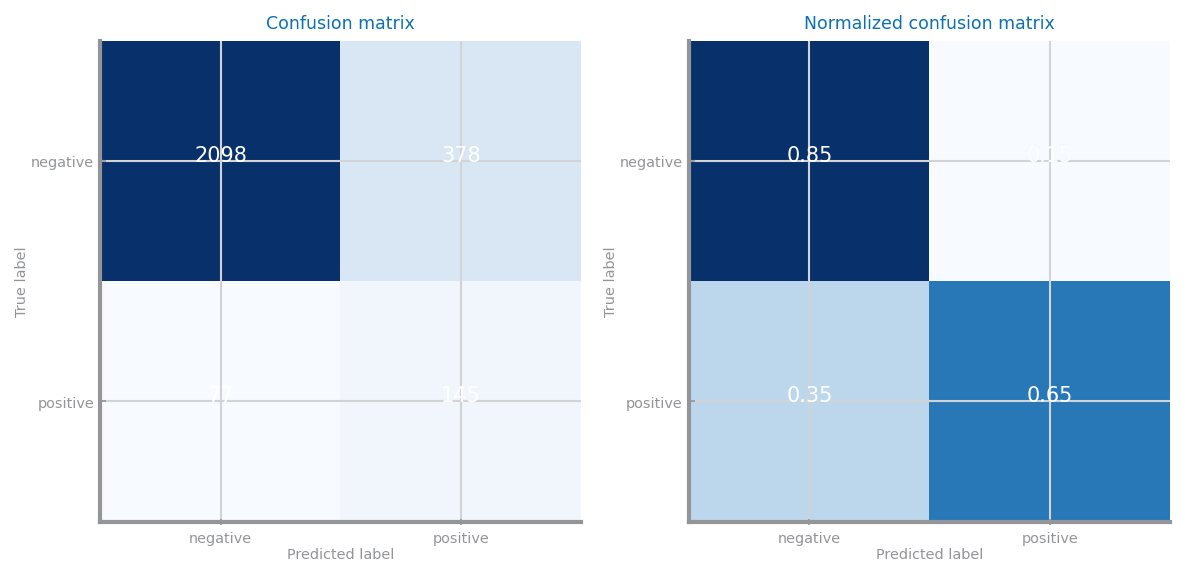

In [6]:
import itertools
import matplotlib.pyplot as plt
CMAP = plt.cm.Blues

def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray, ax: plt.Axes = None,
                          normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='w', horizontalalignment="center")

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(cnf_mtx, labels, ax=axs[0,0])
plot_confusion_matrix(metrics.confusion_matrix(tstY, prdY, labels), labels, axs[0,1], normalize=True)
plt.tight_layout()
plt.show()

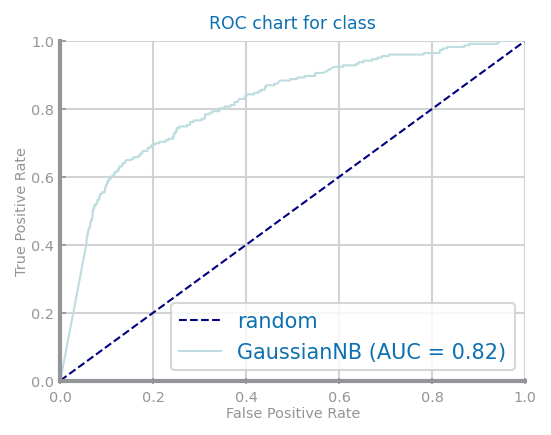

In [7]:
def plot_roc_chart(models: dict, tstX: np.ndarray, tstY: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    for clf in models.keys():
        metrics.plot_roc_curve(models[clf], tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")

model = GaussianNB().fit(trnX, trnY)

plt.figure()
plot_roc_chart({'GaussianNB': model}, tstX, tstY, target='class')
plt.show()

# <font color='gray'> Naive Bayes</font>

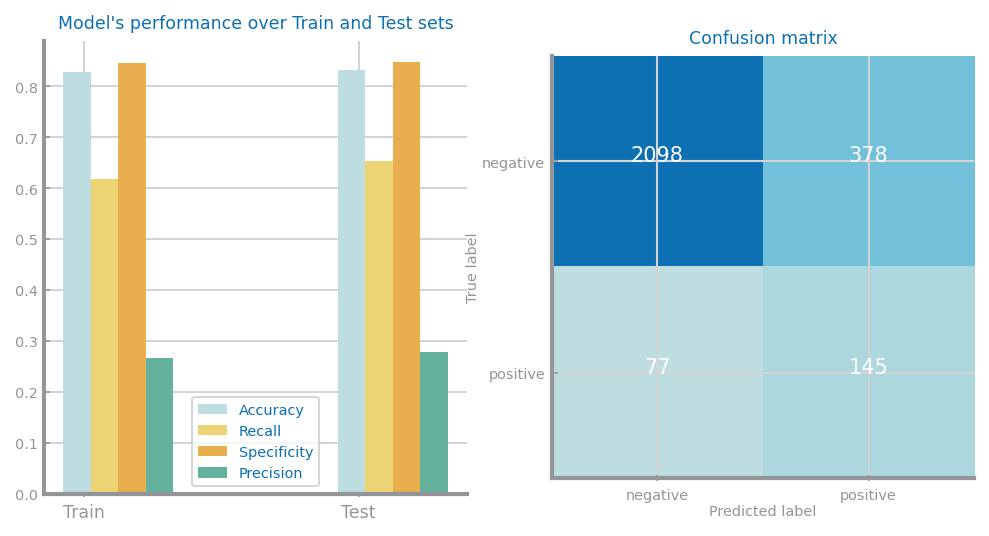

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import ds_functions as ds

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

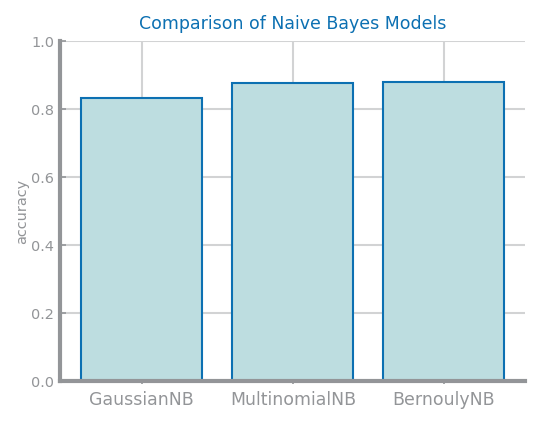

In [9]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulyNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

# <font color='gray'> KNN</font>

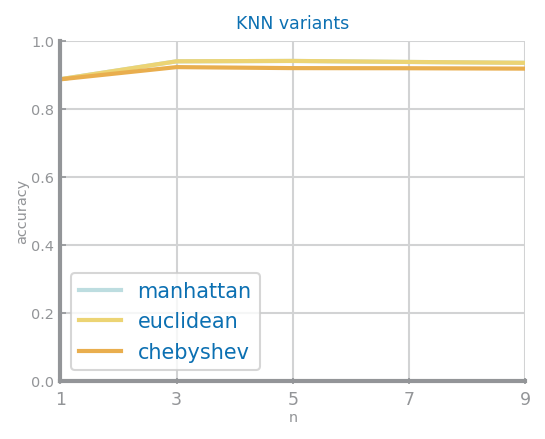

Best results with 5 neighbors and manhattan


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
import ds_functions as ds

nvalues = [1, 3, 5, 7, 9]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
train_values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    y_trn_values = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        prd_trn_Y = knn.predict(trnX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues
    train_values[d] = y_trn_values

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

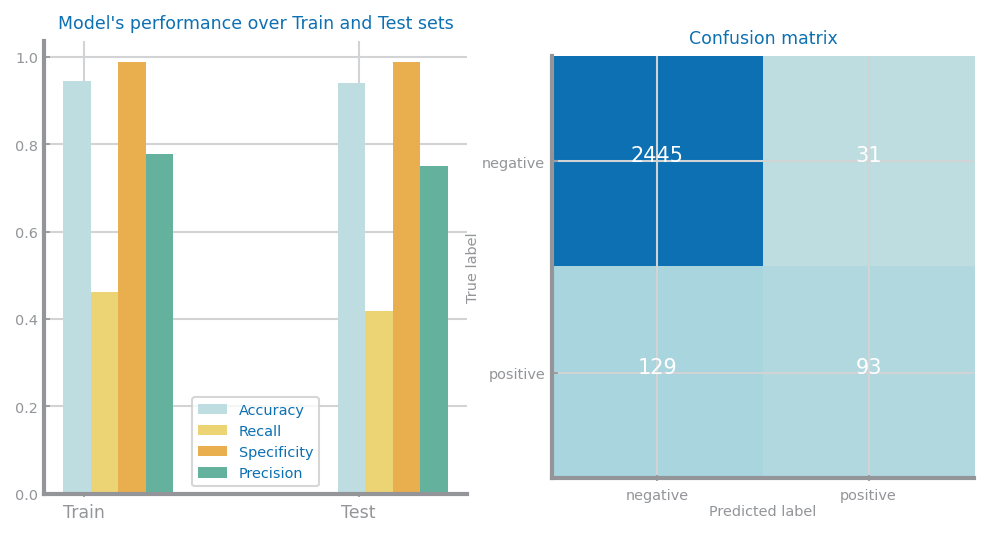

In [11]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

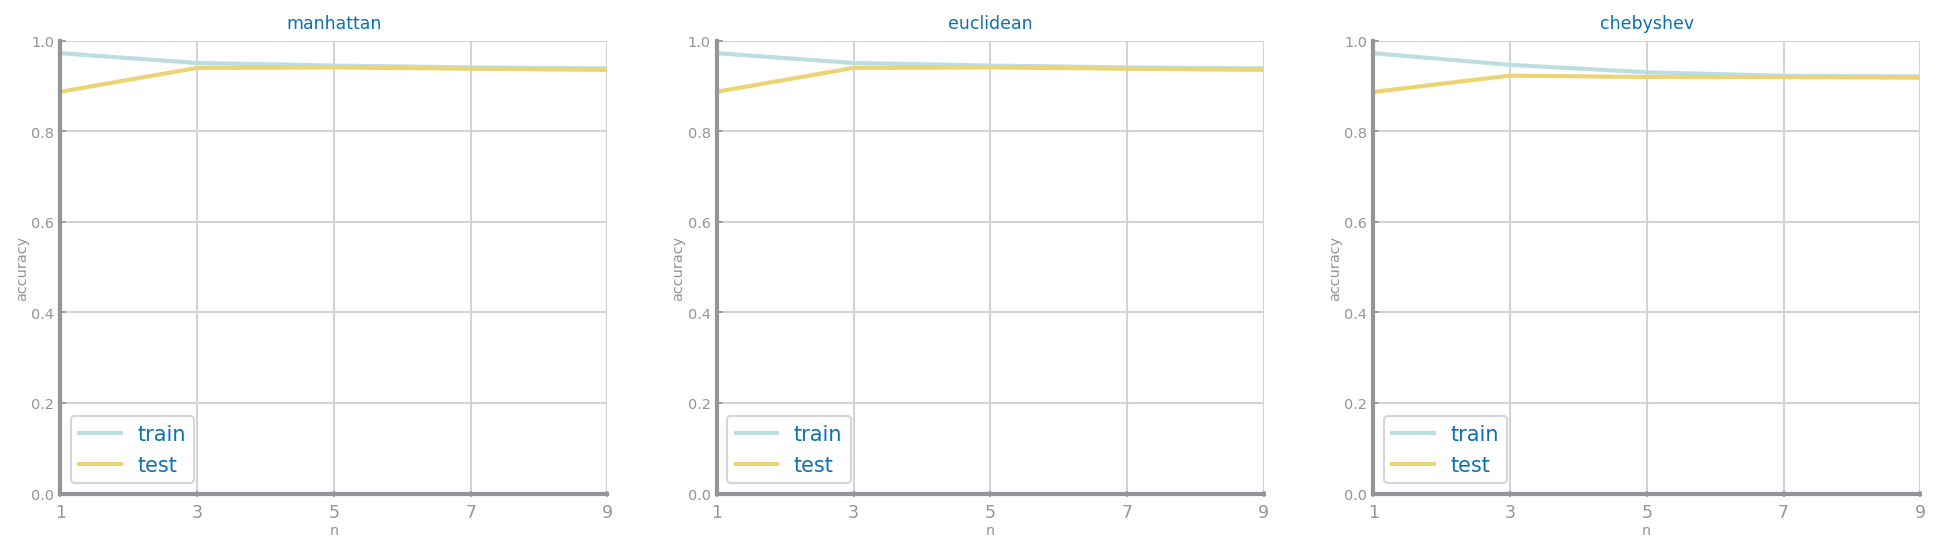

In [12]:
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
for i in range(len(dist)):
    ds.multiple_line_chart(nvalues, {'train': train_values[dist[i]], 'test': values[dist[i]]}, ax=axs[0, i], title=dist[i], xlabel='n', ylabel='accuracy', percentage=True)
plt.show()

# <font color='gray'>Decision Trees</font>

<Figure size 600x450 with 0 Axes>

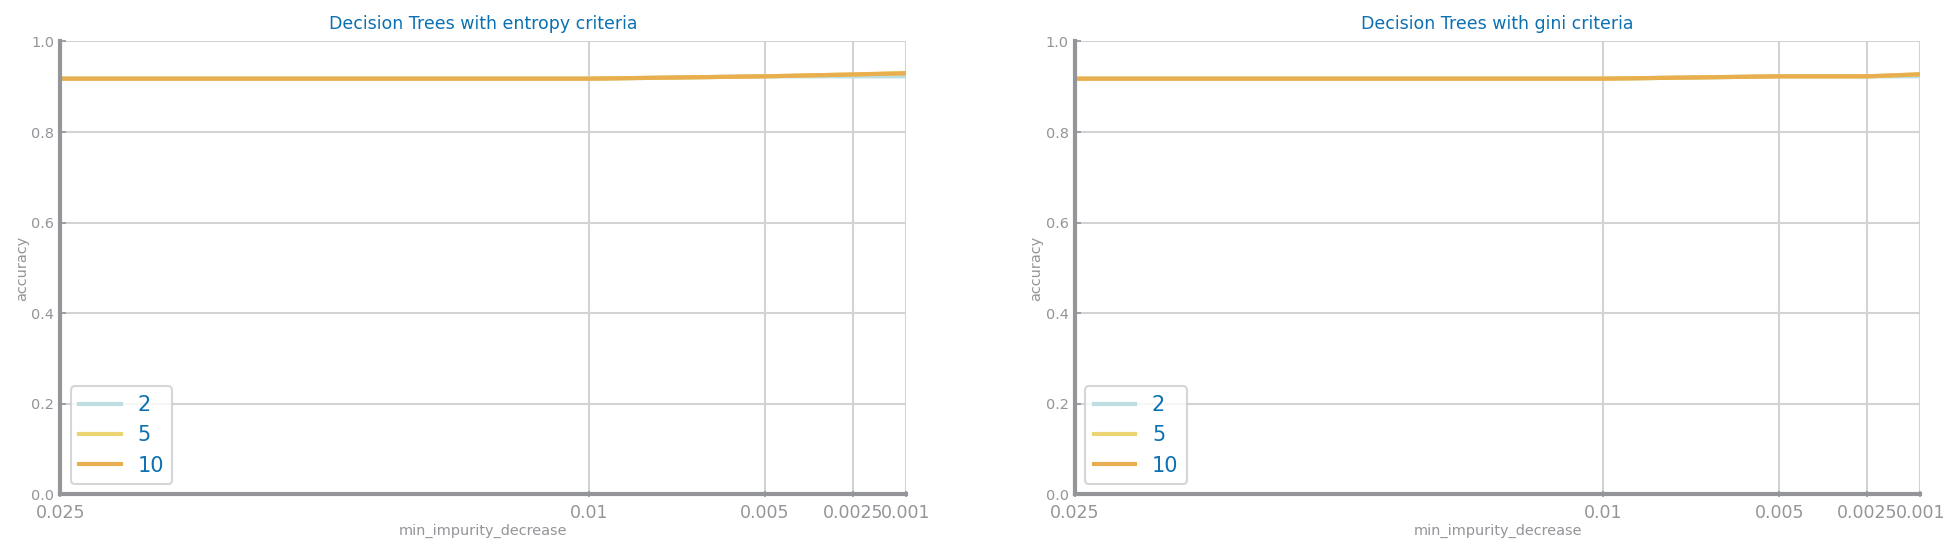

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.00 ==> accuracy=0.93


In [13]:
from sklearn.tree import DecisionTreeClassifier

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None

criteria_test_values = {}
criteria_train_values = {}

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    train_values = {}
    for d in max_depths:
        yvalues = []
        y_trn_values = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            prd_trn_Y = tree.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
        train_values[d] = y_trn_values
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
    
    criteria_test_values[f] = values
    criteria_train_values[f] = train_values
    

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

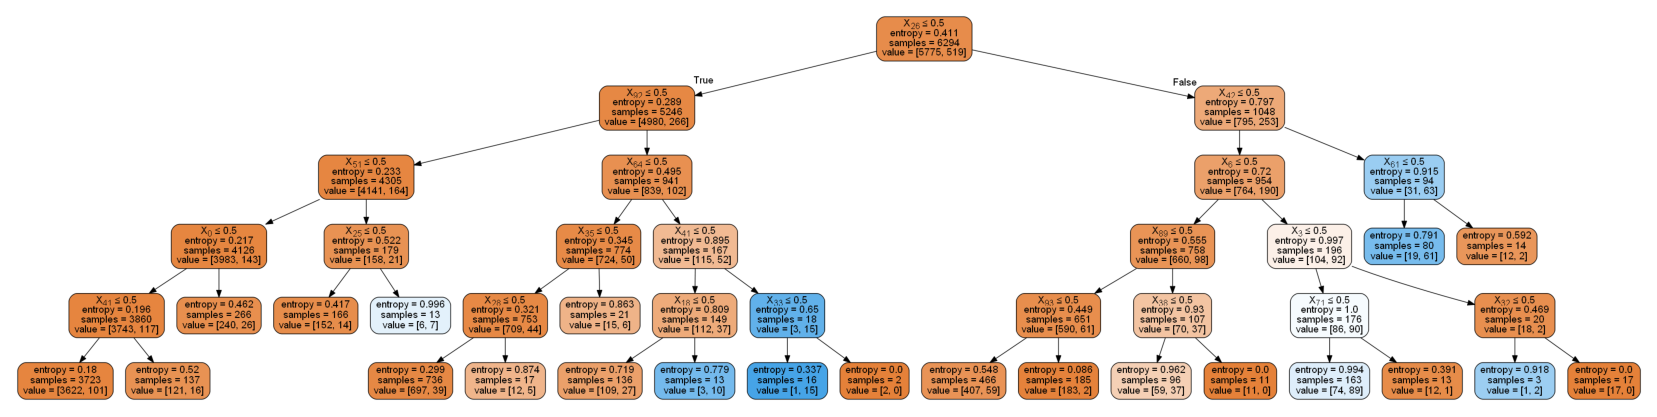

In [14]:
from sklearn.tree import export_graphviz
import pydot

dot_data = export_graphviz(best_tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
# Convert to png
(graph,) = pydot.graph_from_dot_file('dtree.dot')
graph.write_png('dtree.png')

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('dtree.png'))
plt.axis('off')
plt.show()

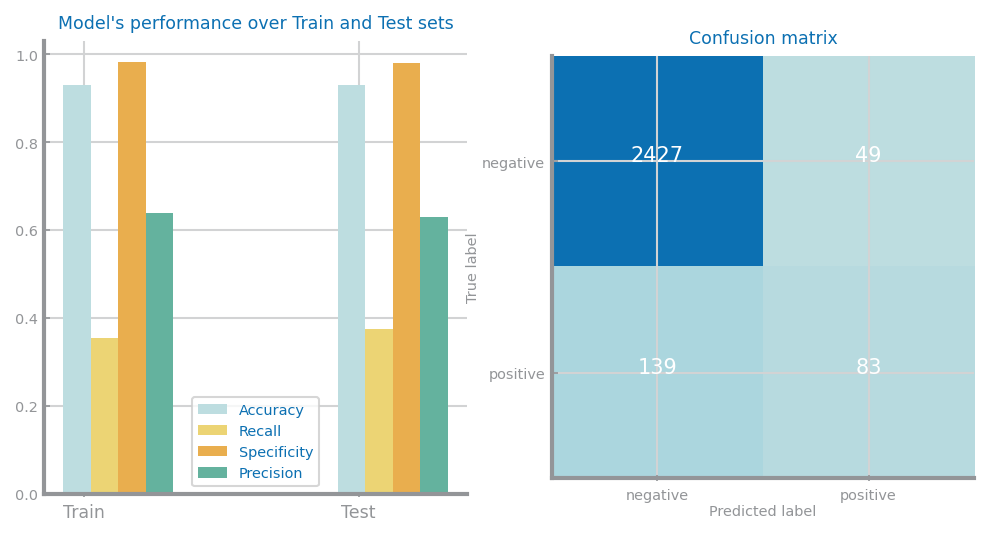

In [15]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

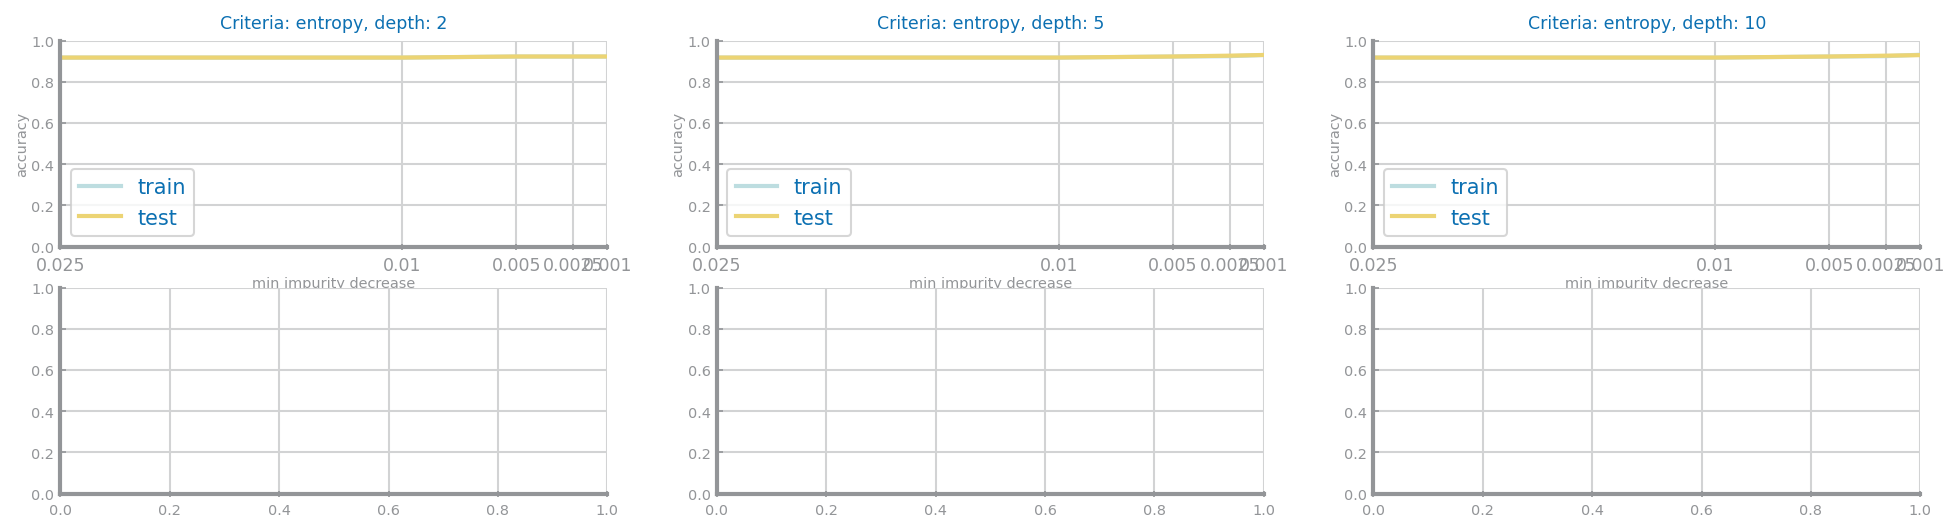

<Figure size 600x450 with 0 Axes>

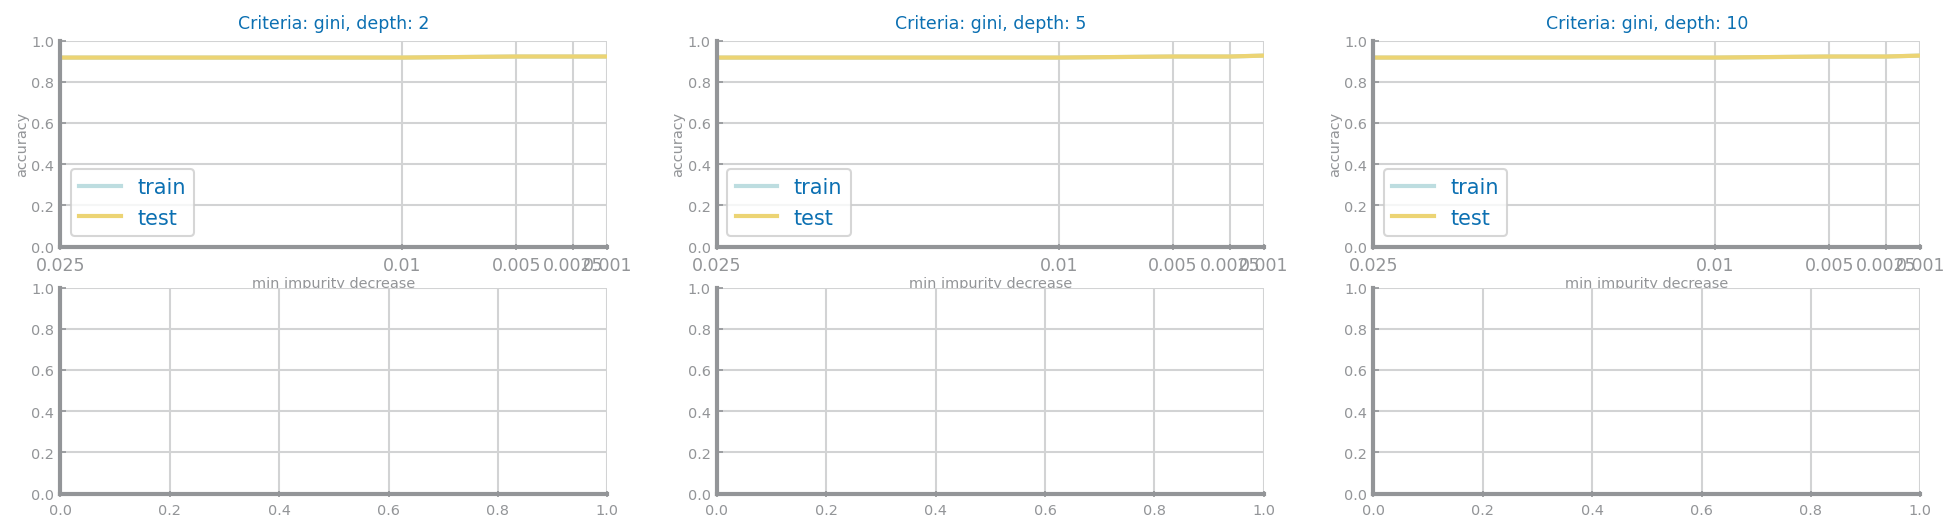

In [16]:
for j in range(len(criteria)):
    train_values = criteria_train_values[criteria[j]]
    test_values = criteria_test_values[criteria[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(max_depths)):
        ds.multiple_line_chart(min_impurity_decrease, {'train': train_values[max_depths[i]], 'test': test_values[max_depths[i]]}, ax=axs[int(i/3), i%3], title='Criteria: ' + criteria[j]+ ', depth: ' + str(max_depths[i]), xlabel='min impurity decrease', ylabel='accuracy', percentage=True)
    plt.show()

# <font color='gray'>Random Forests</font>

<Figure size 600x450 with 0 Axes>

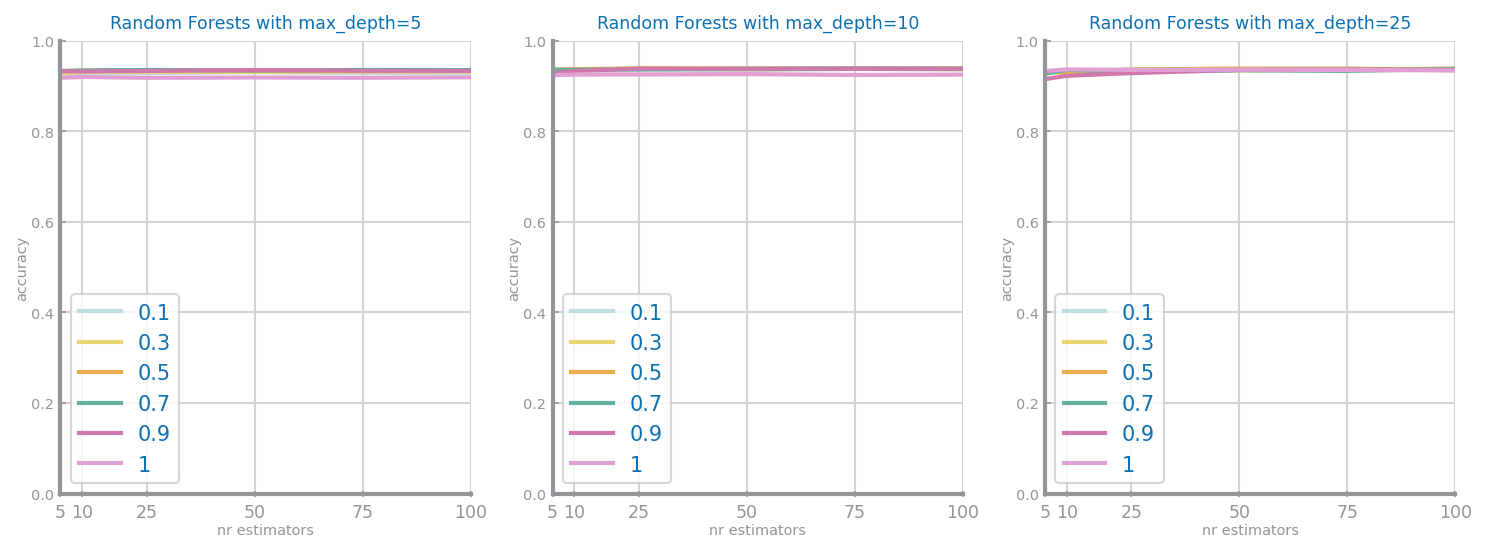

Best results with depth=10, 0.30 features and 25 estimators, with accuracy=0.94


In [17]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

n_estimators = [5, 10, 25, 50, 75, 100]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None


max_depth_test_values = {}
max_depth_train_values = {}

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    train_values = {}
    for f in max_features:
        yvalues = []
        y_trn_values = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            prd_trn_y = rf.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
        train_values[f] = y_trn_values
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    
    max_depth_test_values[max_depths[k]] = values
    max_depth_train_values[max_depths[k]] = train_values
    
    
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

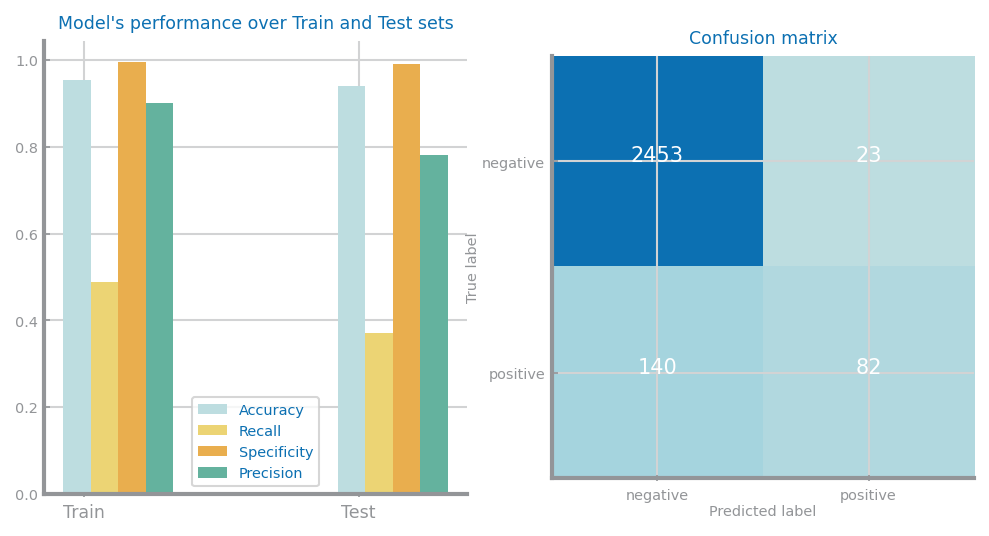

In [18]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

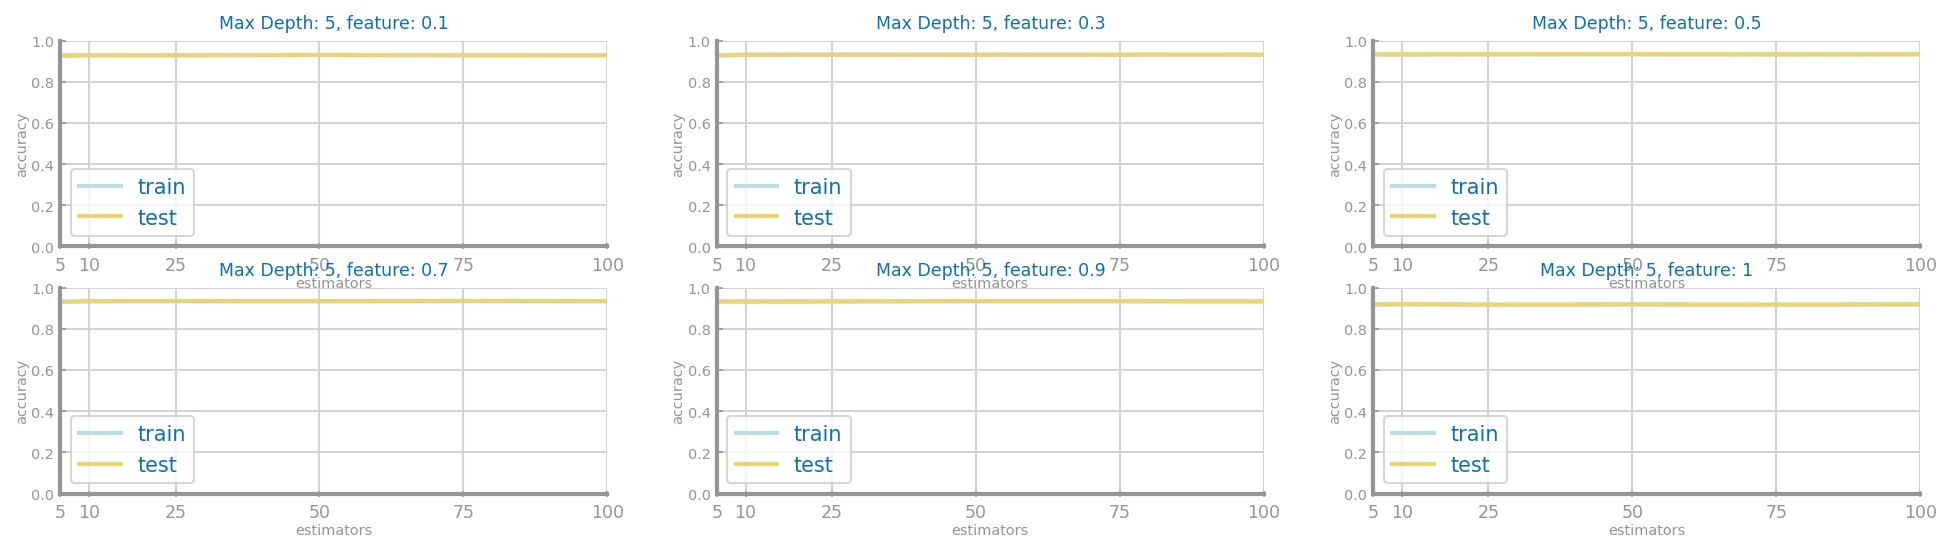

<Figure size 600x450 with 0 Axes>

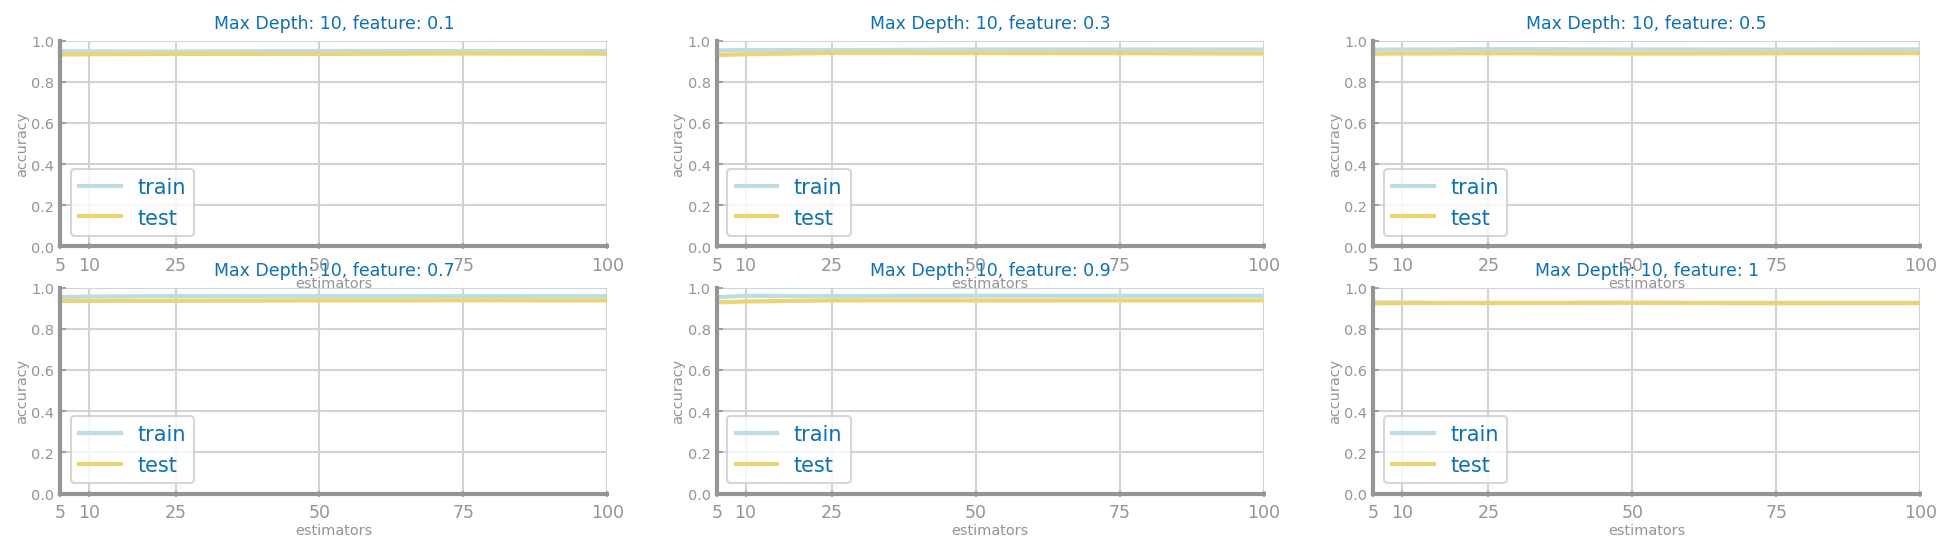

<Figure size 600x450 with 0 Axes>

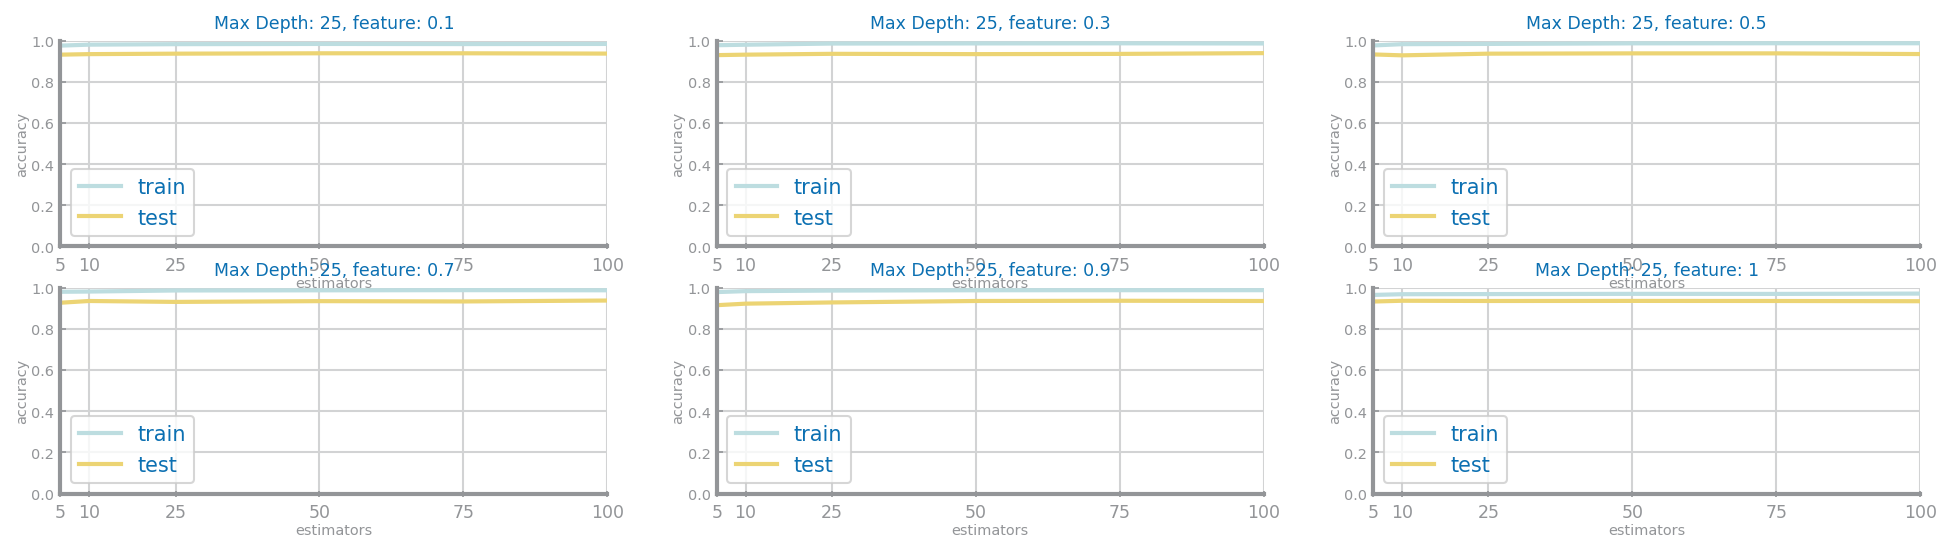

In [19]:
for j in range(len(max_depths)):
    train_values = max_depth_train_values[max_depths[j]]
    test_values = max_depth_test_values[max_depths[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(max_features)):
        ds.multiple_line_chart(n_estimators, {'train': train_values[max_features[i]], 'test': test_values[max_features[i]]}, ax=axs[int(i/3), i%3], title='Max Depth: ' + str(max_depths[j]) + ', feature: ' + str(max_features[i]), xlabel='estimators', ylabel='accuracy', percentage=True)
    plt.show()

# <font color='gray'>Logistic Regression - Original Data</font>

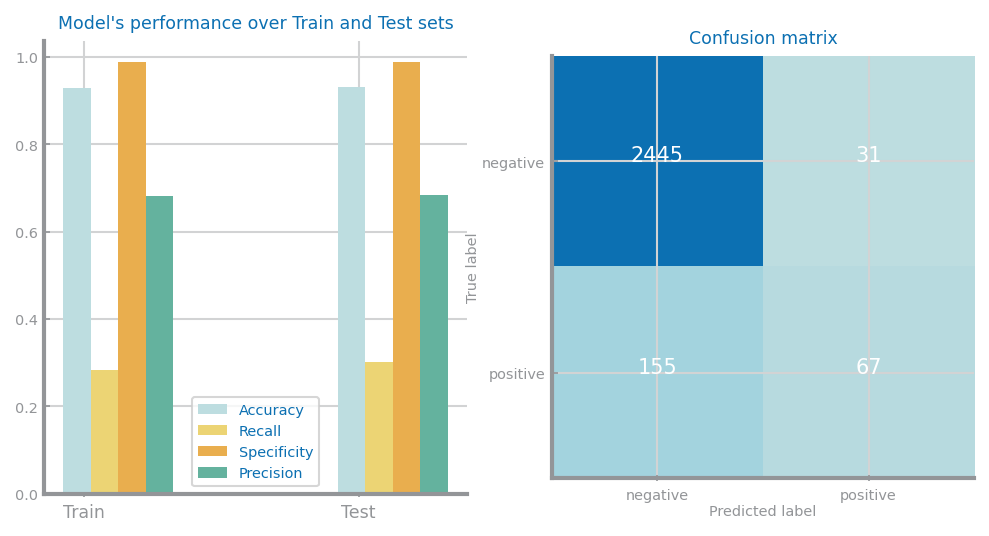

In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state = 0)
clf = clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)

ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

# <font color='gray'>Gradient Boosting - Original Data</font>

<Figure size 600x450 with 0 Axes>

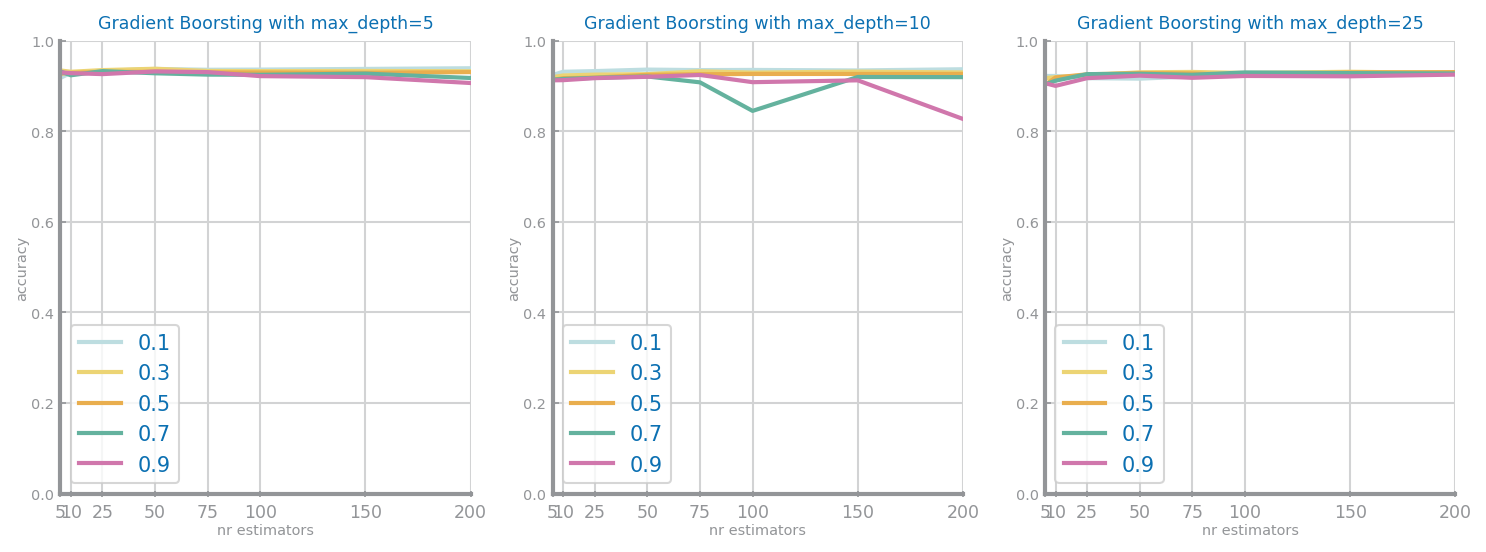

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
import ds_functions as ds

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200]
max_depths = [5, 10, 25]
learning_rate = [.1, .3, .5, .7, .9]
best = ('', 0, 0)
last_best = 0
best_tree = None

max_depth_test_values = {}
max_depth_train_values = {}

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    train_values = {}
    for lr in learning_rate:
        yvalues = []
        y_trn_values = []
        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX, trnY)
            prdY = gb.predict(tstX)
            prd_trn_y = gb.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_tree = gb
        values[lr] = yvalues
        train_values[lr] = y_trn_values
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boorsting with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    max_depth_test_values[max_depths[k]] = values
    max_depth_train_values[max_depths[k]] = train_values

plt.show()

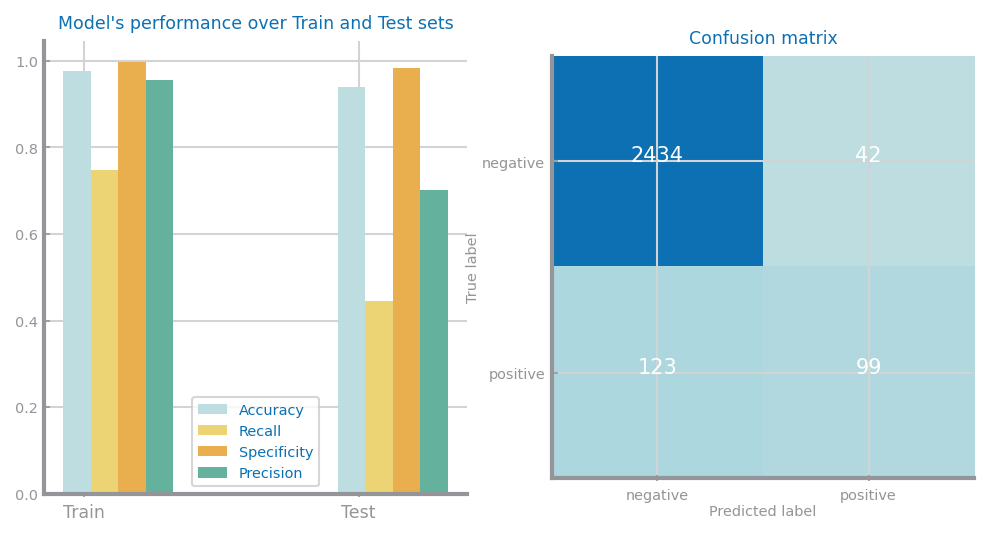

In [22]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

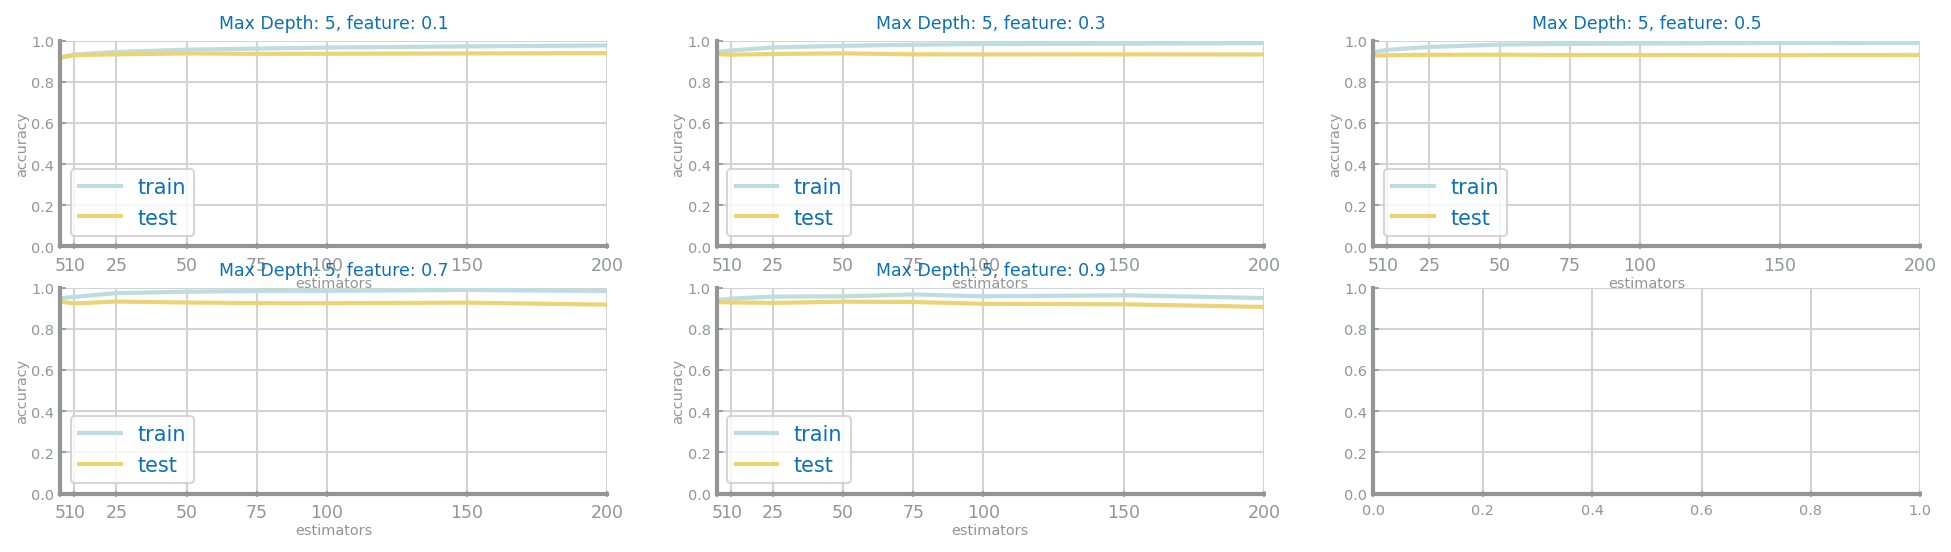

<Figure size 600x450 with 0 Axes>

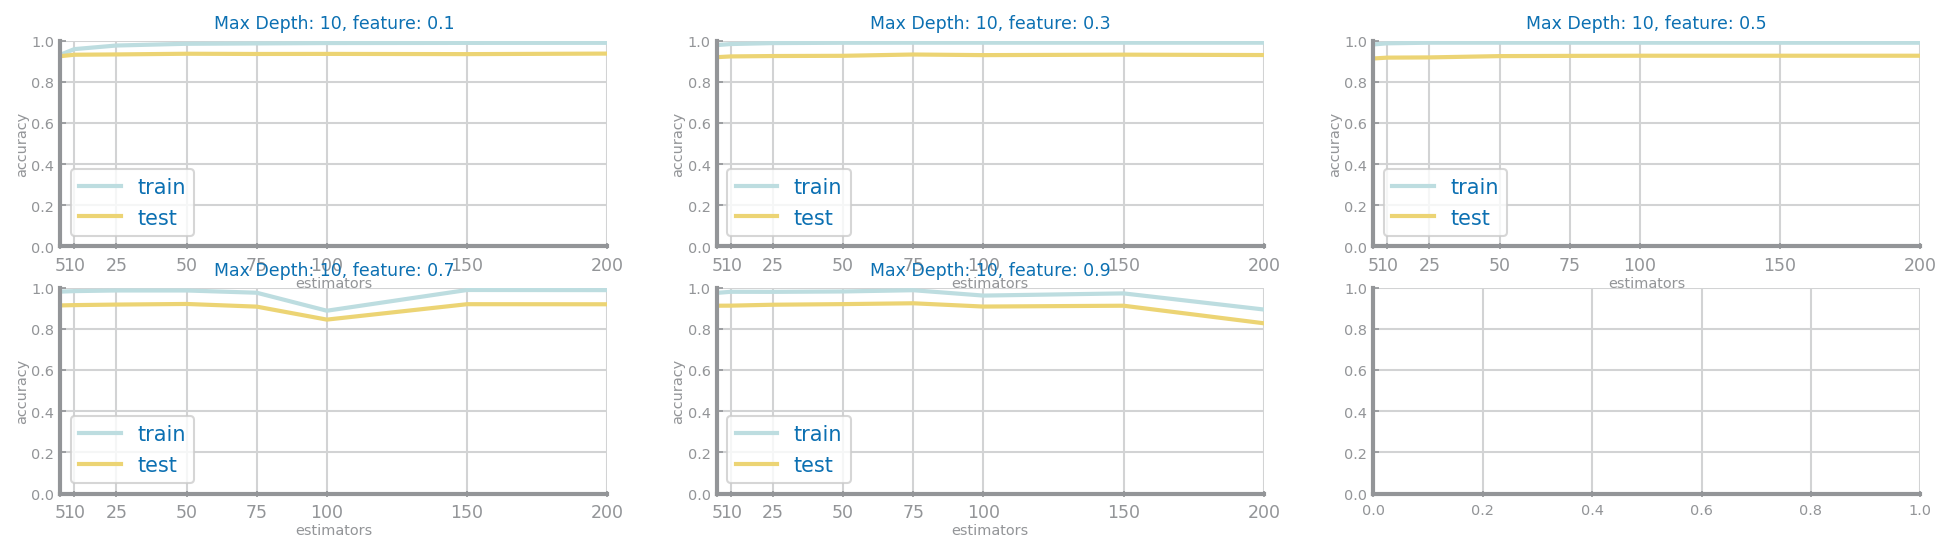

<Figure size 600x450 with 0 Axes>

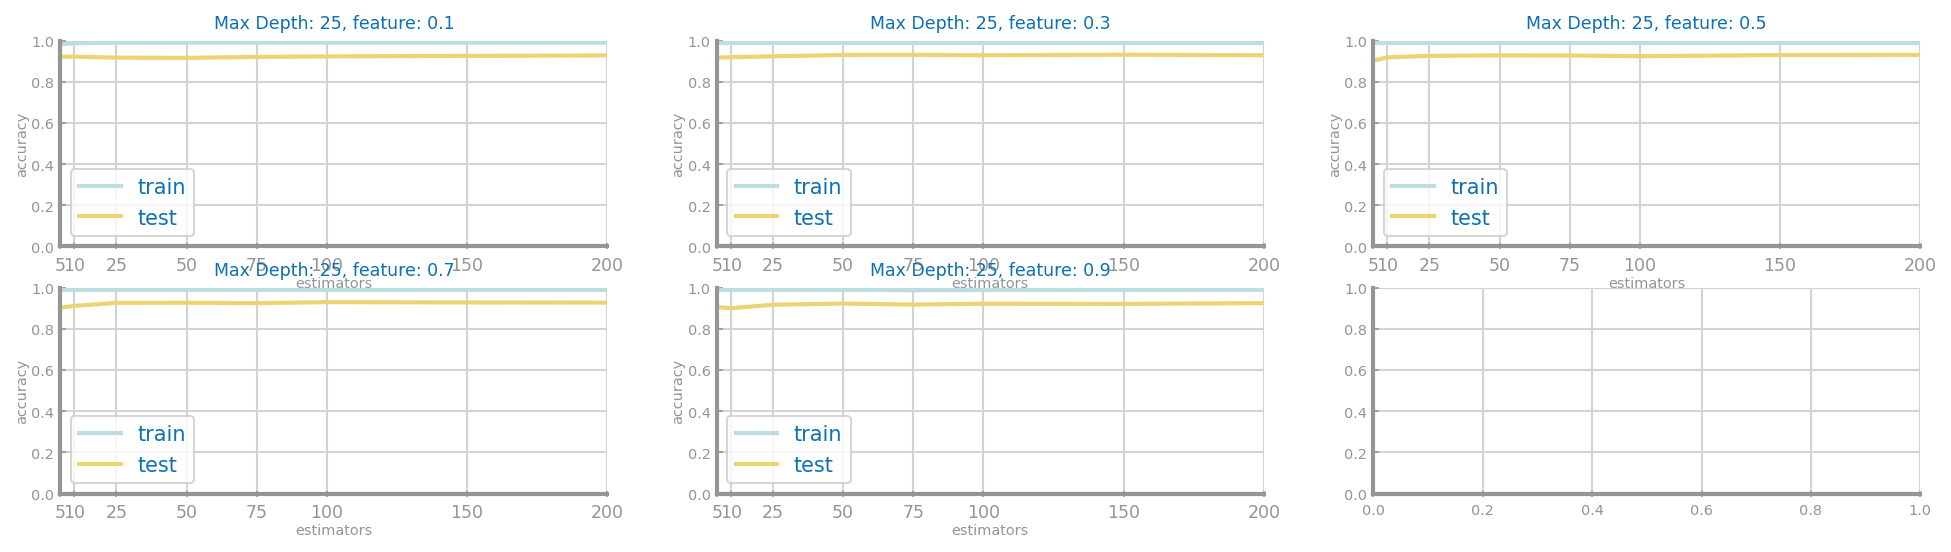

In [23]:
for j in range(len(max_depths)):
    train_values = max_depth_train_values[max_depths[j]]
    test_values = max_depth_test_values[max_depths[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(learning_rate)):
        ds.multiple_line_chart(n_estimators, {'train': train_values[learning_rate[i]], 'test': test_values[learning_rate[i]]}, ax=axs[int(i/3), i%3], title='Max Depth: ' + str(max_depths[j]) + ', feature: ' + str(learning_rate[i]), xlabel='estimators', ylabel='accuracy', percentage=True)
    plt.show()